In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# This relates to plotting datetime values with matplotlib:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
df = pd.read_csv('C:\\Works\\Personal\\repo\\PYTORCH_NOTEBOOKS\\Data\\TimeSeriesData\\Alcohol_Sales.csv',index_col=0,parse_dates=True)

In [5]:
len(df)

325

In [6]:
df = df.dropna()

In [7]:
len(df)

325

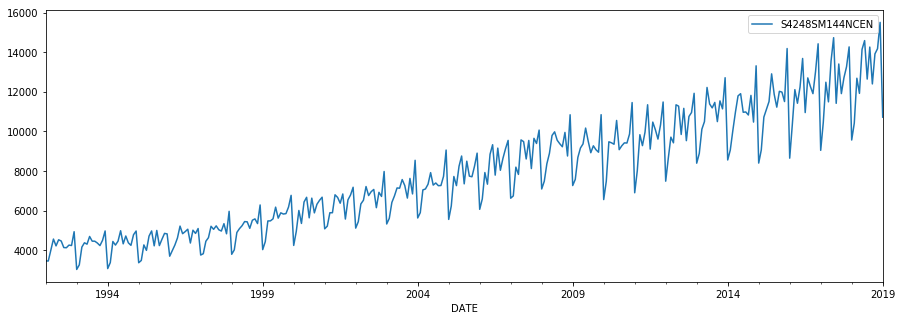

In [10]:
df.plot(figsize=(15,5))

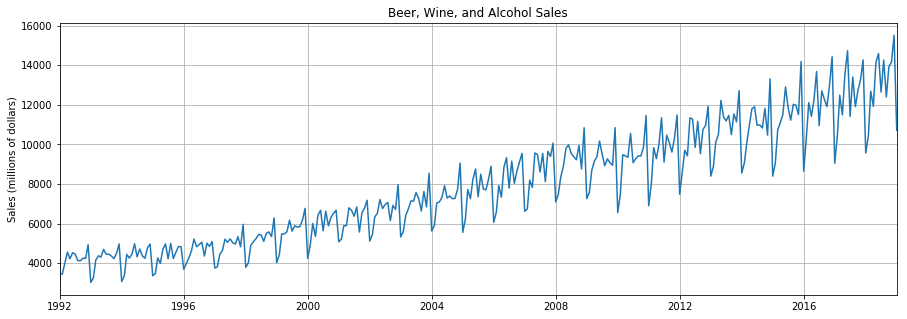

In [22]:
plt.figure(figsize=(15,5))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.show()

In [13]:
y = df['S4248SM144NCEN'].values.astype(float)

In [17]:
test_size = 12

In [18]:
train_set = y[:-test_size]
test_set = y[-test_size:]

In [19]:
test_set

array([10415., 12683., 11919., 14138., 14583., 12640., 14257., 12396.,
       13914., 14174., 15504., 10718.])

In [23]:
from sklearn.preprocessing import MinMaxScaler

#instantiating a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

In [24]:
#normalizing the training set
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [26]:
train_norm[:11]

array([[-0.92683135],
       [-0.92700231],
       [-0.83400291],
       [-0.73792632],
       [-0.79656381],
       [-0.74390974],
       [-0.75467989],
       [-0.81092401],
       [-0.81280451],
       [-0.79006753],
       [-0.79331567]])

In [27]:
print(train_norm.min())
print(train_norm.max())

-1.0
1.0


In [28]:
#converting train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

In [29]:
#defining a window size
window_size = 12

#defining function to create seq/label tuples
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

#applying the input_data function to train_norm
train_data = input_data(train_norm,window_size)
len(train_data)  # this should equal 325-12-12

301

In [30]:
#displaying the first seq/label tuple in the train data
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))

In [31]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        #adding an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        #adding a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        #initializing h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  #only want the last value

In [32]:
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [33]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   400
 40000
   400
   400
   100
     1
______
 41301


In [34]:
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):
    
    # extract the sequence & label from the training data
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.25314346
Epoch:  2 Loss: 0.37523878
Epoch:  3 Loss: 0.39012098
Epoch:  4 Loss: 0.34949699
Epoch:  5 Loss: 0.33077896
Epoch:  6 Loss: 0.33230731
Epoch:  7 Loss: 0.32667691
Epoch:  8 Loss: 0.32077038
Epoch:  9 Loss: 0.30651760
Epoch: 10 Loss: 0.29517019
Epoch: 11 Loss: 0.26913935
Epoch: 12 Loss: 0.25979361
Epoch: 13 Loss: 0.24600053
Epoch: 14 Loss: 0.22227803
Epoch: 15 Loss: 0.18593730
Epoch: 16 Loss: 0.18445705
Epoch: 17 Loss: 0.17432655
Epoch: 18 Loss: 0.25822312
Epoch: 19 Loss: 0.22420478
Epoch: 20 Loss: 0.23121868
Epoch: 21 Loss: 0.19758533
Epoch: 22 Loss: 0.18988022
Epoch: 23 Loss: 0.21032184
Epoch: 24 Loss: 0.16950732
Epoch: 25 Loss: 0.14586549
Epoch: 26 Loss: 0.11828811
Epoch: 27 Loss: 0.00027535
Epoch: 28 Loss: 0.00681852
Epoch: 29 Loss: 0.05630350
Epoch: 30 Loss: 0.01223376
Epoch: 31 Loss: 0.02709176
Epoch: 32 Loss: 0.03447094
Epoch: 33 Loss: 0.02249899
Epoch: 34 Loss: 0.01159327
Epoch: 35 Loss: 0.01592799
Epoch: 36 Loss: 0.00303702
Epoch: 37 Loss: 0.00015524
E

In [35]:
future = 12

#adding the last window of training values to the list of predictions
preds = train_norm[-window_size:].tolist()

# Setting the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [36]:
#displaying predicted values
preds[window_size:]    # equivalent to preds[-future:]

[0.3245275914669037,
 0.5227924585342407,
 0.5454435348510742,
 0.8364425301551819,
 1.104264736175537,
 0.30810344219207764,
 0.8207511901855469,
 0.5576714873313904,
 0.5653725862503052,
 0.8198413848876953,
 0.9293676018714905,
 0.12615284323692322]

In [37]:
#inverting the normarlization to compare with the true labels
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[10778.82414629],
       [11938.5744862 ],
       [12071.07195711],
       [13773.27058014],
       [15339.89657426],
       [10682.7510851 ],
       [13681.48408699],
       [12142.59936514],
       [12187.64694327],
       [13676.1621809 ],
       [14316.83578715],
       [ 9618.43105651]])

In [38]:
#the stop date has to be later than the last predicted value.
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
       '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
       '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
      dtype='datetime64[D]')

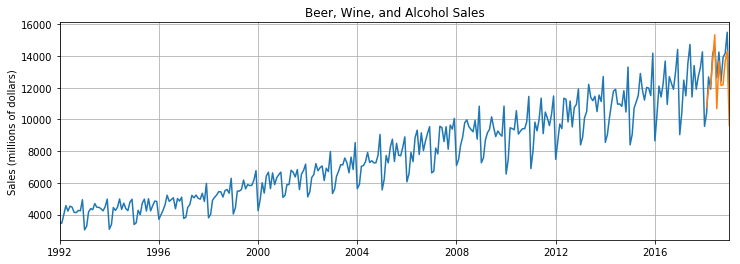

In [39]:
#plotting the predicted vs true values
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions)
plt.show()

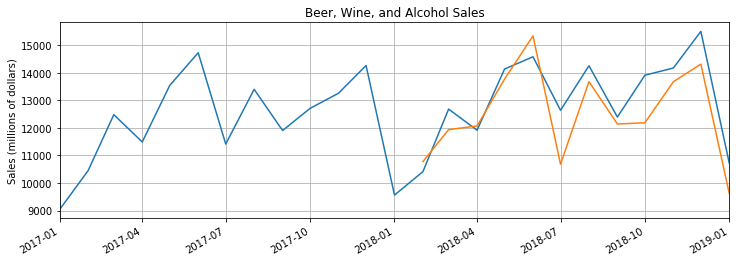

In [40]:
#plotting the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()

In [41]:
epochs = 100

# setting model to back to training mode
model.train()

# feature scaling the entire dataset
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

import time
start_time = time.time()

for epoch in range(epochs):
    
    # training on the full set of sequences
    for seq, y_train in all_data:  
        
        # resetting the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # printing training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.02658496
Epoch:  2 Loss: 0.02985313
Epoch:  3 Loss: 0.01421225
Epoch:  4 Loss: 0.01419733
Epoch:  5 Loss: 0.01290122
Epoch:  6 Loss: 0.01244991
Epoch:  7 Loss: 0.01119690
Epoch:  8 Loss: 0.00854800
Epoch:  9 Loss: 0.00788417
Epoch: 10 Loss: 0.00792318
Epoch: 11 Loss: 0.00556064
Epoch: 12 Loss: 0.00598394
Epoch: 13 Loss: 0.00537636
Epoch: 14 Loss: 0.00649350
Epoch: 15 Loss: 0.00798889
Epoch: 16 Loss: 0.00699036
Epoch: 17 Loss: 0.00741554
Epoch: 18 Loss: 0.00671443
Epoch: 19 Loss: 0.00555703
Epoch: 20 Loss: 0.00517232
Epoch: 21 Loss: 0.00519288
Epoch: 22 Loss: 0.00412102
Epoch: 23 Loss: 0.00535119
Epoch: 24 Loss: 0.00888540
Epoch: 25 Loss: 0.00753472
Epoch: 26 Loss: 0.00589289
Epoch: 27 Loss: 0.00580891
Epoch: 28 Loss: 0.00776316
Epoch: 29 Loss: 0.00629479
Epoch: 30 Loss: 0.00895946
Epoch: 31 Loss: 0.00883982
Epoch: 32 Loss: 0.00968022
Epoch: 33 Loss: 0.00415197
Epoch: 34 Loss: 0.00383917
Epoch: 35 Loss: 0.00253066
Epoch: 36 Loss: 0.00149691
Epoch: 37 Loss: 0.00340568
E

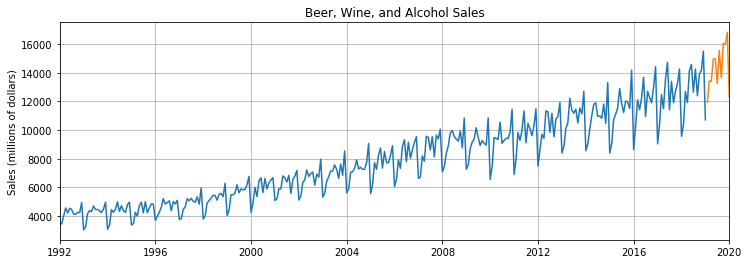

In [42]:
window_size = 12
future = 12
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        #resetting the hidden parameters here!
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())

# Inverse-normalizing the prediction set
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

# plotting the result
# Setting a data range for the predicted data.
# the stop date has to be later than the last predicted value.
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions[window_size:])
plt.show()

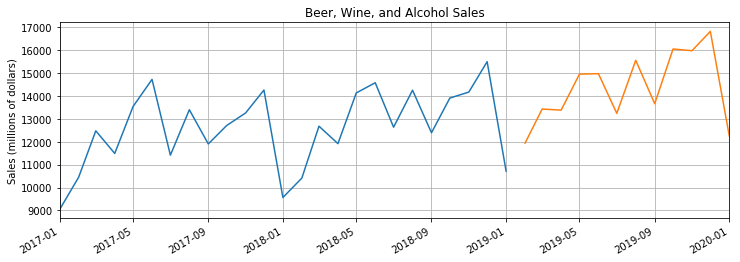

In [43]:
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions[window_size:])
plt.show()